<a href="https://colab.research.google.com/github/PattarapornH/Crab-Molting-Detection/blob/master/Molting_crab_tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Preprocess

In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/Year4/Project/local_modules')

In [0]:
case = ['Case1_(1_1)','Case2_(4_8)','Case4_(1_4)','Case6_(4_9)','Case8_(5_4)',
        'Case9_(3_6)','Case10_(5_2)','Case11_(1_4)']

rect_val = [(80,15,38,55,12,15),(80,15,38,55,12,15),(70,15,38,55,11,15),(70,15,38,55,11,15),(70,15,38,55,11,15),
            (70,15,40,55,11,15),(70,15,40,55,11,15),(70,15,40,55,11,15)]

In [31]:
from preprocess import prep
from tqdm import tqdm

# time_series = [dict(key : [[],[]]),...]
pre = prep()
time_series = []
for i in tqdm(range(len(case)),ncols = 100):
  try:
    # return as dictionary --> key : [diff,white]
    time_series.append(pre.get_time_series(case=case[i],rect_value=rect_val[i]))
  except:
    print(case[i])
  # print('')

100%|█████████████████████████████████████████████████████████████████| 8/8 [07:37<00:00, 56.01s/it]


In [32]:
len(time_series)

8

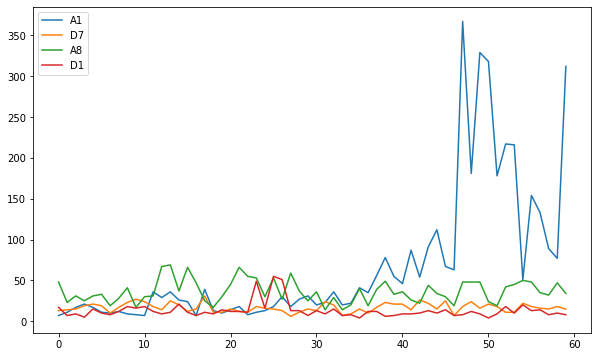

In [33]:
# DIFF
plt.figure(figsize=(10,6))
plt.plot(time_series[0]['A1'][0], label='A1')
plt.plot(time_series[0]['D7'][0], label='D7')
plt.plot(time_series[0]['A8'][0], label='A8')
plt.plot(time_series[0]['D1'][0], label='D1')
plt.legend()

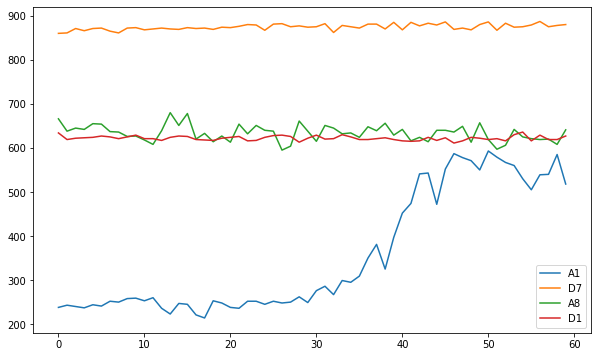

In [34]:
# WHITE
plt.figure(figsize=(10,6))
plt.plot(time_series[0]['A1'][1], label='A1')
plt.plot(time_series[0]['D7'][1], label='D7')
plt.plot(time_series[0]['A8'][1], label='A8')
plt.plot(time_series[0]['D1'][1], label='D1')
plt.legend()

In [0]:
def DA_Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+myNoise

In [0]:
molt = ['A1','D8','A4','C9','D4','C6','E2','A4']

augmented_diff = []
augmented_white = []

for i,time in enumerate(time_series):
  for key in time.keys():
    if(key == molt[i]):
      for j in range(10):
        diff = np.array(time[key][0])
        white = np.array(time[key][1])
        augmented_diff.append(DA_Jitter(diff,np.std(diff)))
        augmented_white.append(DA_Jitter(white,np.std(white)))



In [66]:
len(augmented_diff)

80

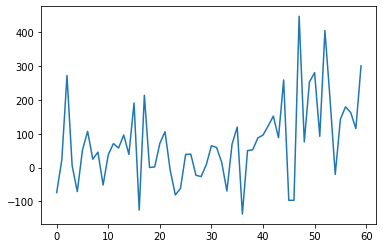

In [68]:
plt.plot(augmented_diff[0])

## Functional API

### Label

In [0]:
molt = ['A1','D8','A4','C9','D4','C6','E2','A4']
X_diff = []
X_white = []
y = []
# time_series --> [dict(key : [[],[]]),...]
for i,time in enumerate(time_series):
  for key in time.keys():
    X_diff.append(time[key][0])
    X_white.append(time[key][1])
    if(key == molt[i]):
      y.append(1)
    else:
      y.append(0)

for i in range(len(augmented_diff)):
  X_diff.append(augmented_diff[i])
  X_white.append(augmented_white[i])
  y.append(1)


In [0]:
# padding
from keras.preprocessing.sequence import pad_sequences

def padding(X):
  max_len = -1
  for x in X:
    if(max_len < len(x)):
      max_len = len(x)
  return pad_sequences(X,padding='post',maxlen = max_len, value=0)

X_diff = padding(X_diff)
X_white = padding(X_white)

In [0]:
X_diff = np.array(X_diff)
X_white = np.array(X_white)
y = np.array(y)

In [72]:
X_diff = np.reshape(X_diff, (X_diff.shape[0], X_diff.shape[1], 1))
X_white = np.reshape(X_white, (X_white.shape[0], X_white.shape[1], 1))

print(X_diff.shape,y.shape)
print(X_white.shape,y.shape)

(480, 78, 1) (480,)
(480, 78, 1) (480,)


In [0]:
from keras.utils import np_utils
y = np_utils.to_categorical(y)

In [74]:
print(X_diff.shape,y.shape)
print(X_white.shape,y.shape)

(480, 78, 1) (480, 2)
(480, 78, 1) (480, 2)


### Model

In [75]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.merge import concatenate
from keras.layers.recurrent import LSTM
from keras.models import Model

# diff_model
input_diff = Input(shape=X_diff.shape[1:])
diff_lstm = LSTM(20)(input_diff)
diff_model = Model(inputs=input_diff, outputs=diff_lstm)
print("DIFF MODEL")
print(diff_model.summary())

# white_model
input_white = Input(shape=X_white.shape[1:])
white_lstm = LSTM(20)(input_white)
white_model = Model(inputs=input_white, outputs=white_lstm)
print("\nWHITE MODEL")
print(white_model.summary())

x = concatenate([diff_lstm,white_lstm])
x = Dense(10)(x)
# x = Dropout(0.3)(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=[input_diff,input_white], outputs=output)
print('\nMODEL')
model.summary()

DIFF MODEL
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 78, 1)             0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 20)                1760      
Total params: 1,760
Trainable params: 1,760
Non-trainable params: 0
_________________________________________________________________
None

WHITE MODEL
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 78, 1)             0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 20)                1760      
Total params: 1,760
Trainable params: 1,760
Non-trainable params: 0
_________________________________________________________________
None

M

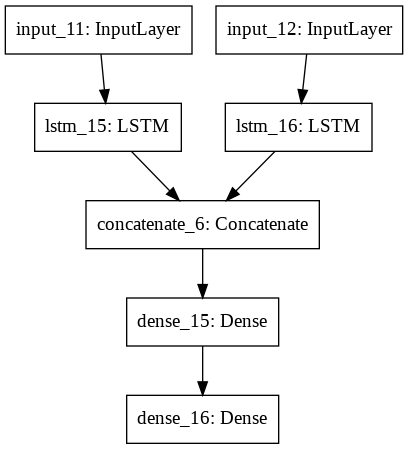

In [76]:
from keras.utils import plot_model
plot_model(model)

In [77]:
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import EarlyStopping

y_int = np.argmax(y,axis=1)
class_weight = compute_class_weight('balanced',np.unique(y_int),y_int)

# class_weight = {0:1,
#                 1:30}

es = EarlyStopping(monitor='val_loss', mode='min')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
train_model = model.fit([X_diff,X_white], y,epochs=50, validation_split=0.3)

Train on 336 samples, validate on 144 samples
Epoch 1/50
336/336 [==============================] - 5s 14ms/step - loss: 0.5517 - acc: 0.9196 - val_loss: 0.8368 - val_acc: 0.4375
Epoch 2/50
336/336 [==============================] - 1s 3ms/step - loss: 0.3759 - acc: 0.9792 - val_loss: 1.0237 - val_acc: 0.4375
Epoch 3/50
336/336 [==============================] - 1s 3ms/step - loss: 0.2313 - acc: 0.9792 - val_loss: 1.4101 - val_acc: 0.4375
Epoch 4/50
336/336 [==============================] - 1s 3ms/step - loss: 0.1287 - acc: 0.9792 - val_loss: 2.1685 - val_acc: 0.4375
Epoch 5/50
336/336 [==============================] - 1s 3ms/step - loss: 0.1191 - acc: 0.9792 - val_loss: 2.7150 - val_acc: 0.4375
Epoch 6/50
336/336 [==============================] - 1s 3ms/step - loss: 0.1127 - acc: 0.9792 - val_loss: 2.2456 - val_acc: 0.4375
Epoch 7/50
336/336 [==============================] - 1s 2ms/step - loss: 0.1026 - acc: 0.9792 - val_loss: 2.0620 - val_acc: 0.4375
Epoch 8/50
336/336 [=========

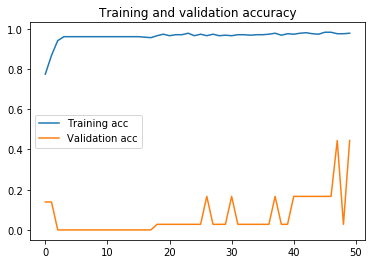

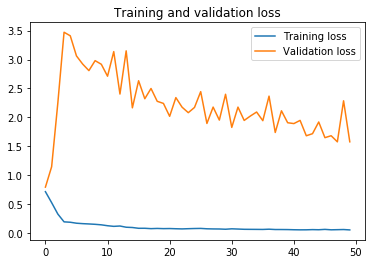

In [57]:
acc = train_model.history['acc']
val_acc = train_model.history['val_acc']
loss = train_model.history['loss']
val_loss = train_model.history['val_loss']


plt.plot(acc, label='Training acc')
plt.plot(val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Predicted

In [0]:
X_test_diff = []
X_test_white = []
y_test = []

for key in time_series[0].keys():
    X_test_diff.append(time_series[0][key][0])
    X_test_white.append(time_series[0][key][1])
    if(key == 'A1'):
      y_test.append(1)
    else:
      y_test.append(0)

In [0]:
X_test_diff = pad_sequences(X_test_diff,padding='post',maxlen = 78, value=0)
X_test_white = pad_sequences(X_test_white,padding='post',maxlen = 78, value=0)

In [0]:
X_test_diff = np.array(X_test_diff)
X_test_white = np.array(X_test_white)
y_test = np.array(y_test)

In [0]:
X_test_diff = np.reshape(X_test_diff, (X_test_diff.shape[0], X_test_diff.shape[1], 1))
X_test_white = np.reshape(X_test_white, (X_test_white.shape[0], X_test_white.shape[1], 1))

print(X_test_diff.shape,y.shape)
print(X_test_white.shape,y.shape)

(50, 78, 1) (400, 2)
(50, 78, 1) (400, 2)


In [0]:
# from keras.utils.np_utils import probas_to_classes
# y_pred = probas_to_classes(model_comp.predict(X_diff))
y_prob = model.predict([X_test_diff,X_test_white]) 
y_pred = y_prob.argmax(axis=-1)
# y_pred = []
# tmp = np.array([item[0] for item in y_prob])
# tmp = np.sort(tmp)
# print(np.mean(tmp),np.std(tmp))
# print(tmp[0:2])
# for prob in y_prob:
#   y_pred.append(int(prob[0] in tmp[0:2]))


In [0]:
def print_output(y):
  for i in range(len(y)):
    print(y[i],end=' ')
    if((i+1)%5 == 0):
      print('\n')
print_output(y_pred)

0 0 0 0 0 

0 0 0 0 0 

0 0 0 0 0 

0 0 0 0 0 

0 0 0 0 0 

0 0 0 0 0 

0 0 0 0 0 

0 0 0 0 0 

0 0 0 0 0 

0 0 0 0 0 



## LSTM Model

### Label

In [0]:
molt = ['A1','D8','A4','C9','D4','C6','E2','A4']
X = []
y = []
# time_series --> [dict(key : [[],[]]),...]
for i,time in enumerate(time_series):
  for key in time.keys():
    tmp = []
    tmp.extend(time[key][0])
    tmp.extend(time[key][1])
    X.append(tmp)
    if(key == molt[i]):
      y.append(1)
    else:
      y.append(0)
  

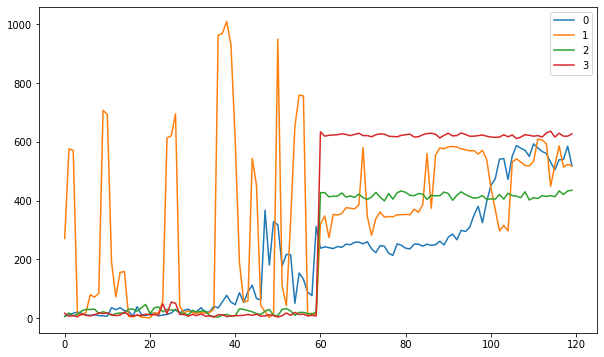

In [20]:
plt.figure(figsize=(10,6))
plt.plot(X[0],label='0')
plt.plot(X[1],label='1')
plt.plot(X[2],label='2')
plt.plot(X[3],label='3')
plt.legend()

In [0]:
# padding
from keras.preprocessing.sequence import pad_sequences

def padding(X):
  max_len = -1
  for x in X:
    if(max_len < len(x)):
      max_len = len(x)
  return pad_sequences(X,padding='pre',maxlen = max_len, value=x[-1])

X = padding(X)

In [0]:
from sklearn.preprocessing import MinMaxScaler
# for i in range(len(X)):
#   X[i] = StandardScaler().fit_transform(X[i])
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [23]:
from keras.utils import np_utils
y = np_utils.to_categorical(y)
y[0]

array([0., 1.], dtype=float32)

In [0]:
X = np.array(X)
y = np.array(y)

In [25]:
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
print(X.shape,y.shape)

(400, 156, 1) (400, 2)


### Model

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

model = Sequential()
model.add(LSTM(50, input_shape=(X.shape[1:]), activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(20, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 156, 50)           10400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 156, 50)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 20)                5680      
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_6 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                

In [30]:
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import EarlyStopping

y_int = np.argmax(y,axis=1)
class_weight = compute_class_weight('balanced',np.unique(y_int),y_int)

# class_weight = {0: 1.,
#                 1: 20.}
es = EarlyStopping(monitor='val_loss', mode='min')
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'],)
train_model = model.fit(X,y,epochs=30, validation_split=0.2,class_weight=class_weight)

Train on 320 samples, validate on 80 samples
Epoch 1/30
320/320 [==============================] - 4s 14ms/step - loss: 0.6762 - acc: 0.8875 - val_loss: 0.6456 - val_acc: 0.9875
Epoch 2/30
320/320 [==============================] - 3s 8ms/step - loss: 0.6070 - acc: 0.9781 - val_loss: 0.5421 - val_acc: 0.9875
Epoch 3/30
320/320 [==============================] - 2s 8ms/step - loss: 0.3677 - acc: 0.9781 - val_loss: 0.2015 - val_acc: 0.9875
Epoch 4/30
320/320 [==============================] - 3s 8ms/step - loss: 0.9066 - acc: 0.9437 - val_loss: 0.2015 - val_acc: 0.9875
Epoch 5/30
320/320 [==============================] - 3s 8ms/step - loss: 0.6569 - acc: 0.9594 - val_loss: 0.2015 - val_acc: 0.9875
Epoch 6/30
320/320 [==============================] - 3s 8ms/step - loss: 0.7576 - acc: 0.9531 - val_loss: 0.2015 - val_acc: 0.9875
Epoch 7/30
320/320 [==============================] - 3s 8ms/step - loss: 0.6044 - acc: 0.9625 - val_loss: 0.2015 - val_acc: 0.9875
Epoch 8/30
320/320 [==========

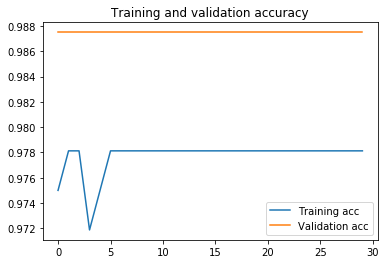

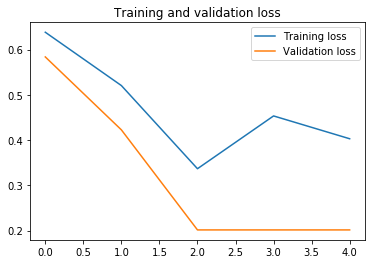

In [28]:
acc = train_model.history['acc']
val_acc = train_model.history['val_acc']
loss = train_model.history['loss']
val_loss = train_model.history['val_loss']

plt.plot(acc, label='Training acc')
plt.plot(val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Predicted

In [0]:
X_test = []
y_test = []

for key in time_series[0].keys():
  tmp = []
  tmp.extend(time_series[0][key][0])
  tmp.extend(time_series[0][key][1])
  X_test.append(tmp)
  if(key == 'A1'):
    y_test.append(1)
  else:
    y_test.append(0)

In [0]:
X_test = pad_sequences(X_test,padding='post',maxlen = 156, value=0)

In [0]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [0]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_test.shape,y.shape)

(50, 156, 1) (400, 2)


In [0]:
y_pred = model.predict_classes(X_test)

In [0]:
def print_output(y):
  for i in range(len(y)):
    print(y[i],end=' ')
    if((i+1)%5 == 0):
      print('\n')
print_output(y_pred)

0 0 0 0 0 

0 0 0 0 0 

0 0 0 0 0 

0 0 0 0 0 

0 0 0 0 0 

0 0 0 0 0 

0 0 0 0 0 

0 0 0 0 0 

0 0 0 0 0 

0 0 0 0 0 



## White Model

### Label

In [0]:
molt = ['A1','D8','A4','C9','D4','C6','E2','A4']
X_diff = []
X_white = []
X_valid = []
y = []
y_valid = []
# time_series --> [dict(key : [[],[]]),...]
for i,time in enumerate(time_series):
  if(i != len(time_series) -1):
    for key in time.keys():
      # X_diff.append(time[key][0])
      X_white.append(time[key][1])
      if(key == molt[i]):
        y.append(1)
      else:
        y.append(0)
  else:
    for key in time.keys():
      X_valid.append(time[key][1])
      # X_diff.append(time[key][0])
      # X_white.append(time[key][1])
      if(key == 'A4'):
        y_valid.append(1)
      else:
        y_valid.append(0) 

In [0]:
# padding
from keras.preprocessing.sequence import pad_sequences

def padding(X):
  max_len = -1
  for x in X:
    if(max_len < len(x)):
      max_len = len(x)
  return pad_sequences(X,padding='post',maxlen = max_len, value=0)

# X_diff = padding(X_diff)
X_white = pad_sequences(X_white,padding='post', value=0)
X_valid = pad_sequences(X_valid,padding='post', maxlen=X_white.shape[1], value=0)

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X_white)
# scaler.fit(X_white)
X_white = scaler.transform(X_white)
X_valid = scaler.transform(X_valid)

In [0]:
# X_diff = np.array(X_diff)
X_valid = np.array(X_valid)
X_white = np.array(X_white)
y = np.array(y)
y_valid = np.array(y_valid)
# print(X_diff.shape)

In [0]:
from keras.utils import np_utils
y = np_utils.to_categorical(y)
y_valid = np_utils.to_categorical(y_valid)

In [0]:
# X_diff = np.reshape(X_diff, (X_diff.shape[0], X_diff.shape[1], 1))
# print(X_diff.shape,y.shape)
X_white = np.reshape(X_white, (X_white.shape[0], X_white.shape[1], 1))
X_valid = np.reshape(X_valid,(X_valid.shape[0], X_valid.shape[1], 1))
print(X_white.shape,y.shape)

(350, 78, 1) (350, 2)


### Model

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

model = Sequential()
model.add(LSTM(10, input_shape=X_white.shape[1:], activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(20, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(12, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 78, 10)            480       
_________________________________________________________________
dropout_37 (Dropout)         (None, 78, 10)            0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 20)                2480      
_________________________________________________________________
dropout_38 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 12)                252       
_________________________________________________________________
dropout_39 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 2)               

In [0]:
# class_weight = {0: 1.,
#                 1: 20.}
from keras.callbacks import EarlyStopping

y_int = np.argmax(y,axis=1)
class_weight = compute_class_weight('balanced',np.unique(y_int),y_int)
# es = EarlyStopping(monitor='val_acc', mode='max')
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'],)
train_model = model.fit(X_white,y,epochs=50, validation_data=(X_valid,y_valid), class_weight=class_weight,)

Train on 350 samples, validate on 50 samples
Epoch 1/50
350/350 [==============================] - 8s 24ms/step - loss: 0.6822 - acc: 0.8771 - val_loss: 0.6635 - val_acc: 0.9800
Epoch 2/50
350/350 [==============================] - 3s 10ms/step - loss: 0.6482 - acc: 0.9800 - val_loss: 0.6227 - val_acc: 0.9800
Epoch 3/50
350/350 [==============================] - 3s 10ms/step - loss: 0.6003 - acc: 0.9800 - val_loss: 0.5580 - val_acc: 0.9800
Epoch 4/50
350/350 [==============================] - 3s 10ms/step - loss: 0.5164 - acc: 0.9800 - val_loss: 0.4177 - val_acc: 0.9800
Epoch 5/50
350/350 [==============================] - 3s 10ms/step - loss: 0.2621 - acc: 0.9800 - val_loss: 0.3224 - val_acc: 0.9800
Epoch 6/50
350/350 [==============================] - 3s 10ms/step - loss: 0.3224 - acc: 0.9800 - val_loss: 0.3224 - val_acc: 0.9800
Epoch 7/50
350/350 [==============================] - 3s 10ms/step - loss: 0.3224 - acc: 0.9800 - val_loss: 0.3224 - val_acc: 0.9800
Epoch 8/50
350/350 [====

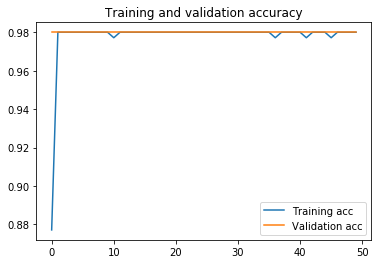

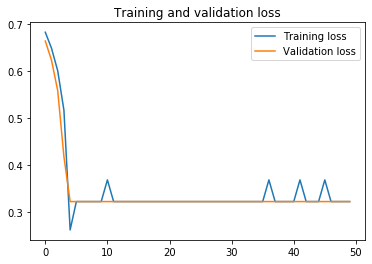

In [0]:
acc = train_model.history['acc']
val_acc = train_model.history['val_acc']
loss = train_model.history['loss']
val_loss = train_model.history['val_loss']


plt.plot(acc, label='Training acc')
plt.plot(val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Predicted

In [0]:
X_test = []
y_test = []

for key in time_series[0].keys():
  X_test.append(time_series[0][key][1])
  if(key == 'A1'):
    y_test.append(1)
  else:
    y_test.append(0)

In [0]:
X_test = scaler.transform(X_test)

ValueError: ignored

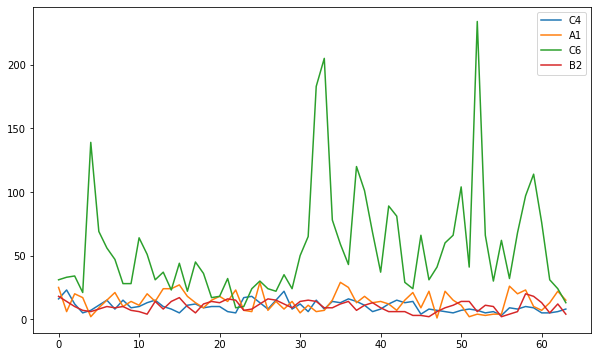

In [0]:
plt.figure(figsize=(10,6))
plt.plot(time_series[5]['C4'][0],label='C4')
plt.plot(time_series[5]['A1'][0],label='A1')
plt.plot(time_series[5]['C6'][0],label='C6')
plt.plot(time_series[5]['B2'][0],label='B2')
plt.legend()

In [0]:
X_test = pad_sequences(X_test,padding='post',maxlen = 113, value=0)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [0]:
y_pred = model.predict_classes(X_test)
y_prob = model.predict_proba(X_test)

In [0]:
y_prob

In [0]:
def print_output(y):
  for i in range(len(y)):
    print(y[i],end=' ')
    if((i+1)%5 == 0):
      print('\n')
print_output(y_pred)

0 0 0 1 1 

0 0 0 1 0 

0 0 0 0 0 

0 1 1 0 0 

0 0 1 1 0 

0 0 0 0 0 

1 1 0 0 0 

0 0 0 0 0 

0 0 1 0 0 

0 1 0 0 0 



## Start Model

### Label

In [0]:
X = []
y = []
for key in time_series[0].keys():
  X.append(time_series[0][key][0])
  if(key == 'A1'):
    y.append(1)
  else:
    y.append(0)

In [0]:
X = np.array(X)
y = np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [0]:
from keras.utils import np_utils
y = np_utils.to_categorical(y)
y[0]

array([0., 1.], dtype=float32)

In [0]:
print(X.shape,y.shape)

(50, 60, 1) (50, 2)


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

### Model

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

model = Sequential()
model.add(LSTM(10, input_shape=(X.shape[1:]), return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(10))
model.add(Dropout(0.4))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_181 (LSTM)              (None, 60, 10)            480       
_________________________________________________________________
dropout_267 (Dropout)        (None, 60, 10)            0         
_________________________________________________________________
lstm_182 (LSTM)              (None, 10)                840       
_________________________________________________________________
dropout_268 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_180 (Dense)            (None, 32)                352       
_________________________________________________________________
dropout_269 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_181 (Dense)            (None, 2)               

In [0]:
from sklearn.utils.class_weight import compute_class_weight

y_int = np.argmax(y,axis=1)
# class_weight = compute_class_weight('balanced',np.unique(y_int),y_int)

class_weight = {0: 1.,
                1: 20.}
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'],)
train_model = model.fit(X,y,epochs=60, validation_split=0.3, class_weight=class_weight)

Train on 35 samples, validate on 15 samples
Epoch 1/60
35/35 [==============================] - 48s 1s/step - loss: 1.1061 - acc: 0.9714 - val_loss: 0.3848 - val_acc: 1.0000
Epoch 2/60
35/35 [==============================] - 1s 17ms/step - loss: 0.8482 - acc: 0.9143 - val_loss: 0.3791 - val_acc: 1.0000
Epoch 3/60
35/35 [==============================] - 1s 16ms/step - loss: 1.0425 - acc: 0.9714 - val_loss: 0.3782 - val_acc: 1.0000
Epoch 4/60
35/35 [==============================] - 1s 16ms/step - loss: 0.8177 - acc: 0.9714 - val_loss: 0.3739 - val_acc: 1.0000
Epoch 5/60
35/35 [==============================] - 1s 16ms/step - loss: 0.8551 - acc: 0.9429 - val_loss: 0.3676 - val_acc: 1.0000
Epoch 6/60
35/35 [==============================] - 1s 16ms/step - loss: 0.9471 - acc: 0.9143 - val_loss: 0.3606 - val_acc: 1.0000
Epoch 7/60
35/35 [==============================] - 1s 16ms/step - loss: 0.9527 - acc: 0.9429 - val_loss: 0.3566 - val_acc: 1.0000
Epoch 8/60
35/35 [======================

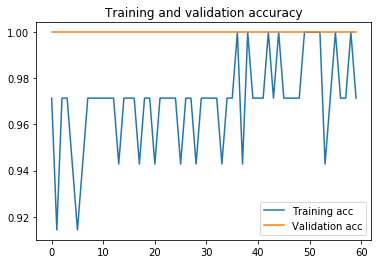

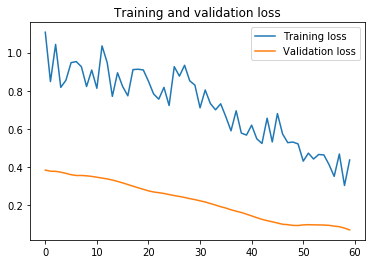

In [0]:
acc = train_model.history['acc']
val_acc = train_model.history['val_acc']
loss = train_model.history['loss']
val_loss = train_model.history['val_loss']

plt.plot(acc, label='Training acc')
plt.plot(val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

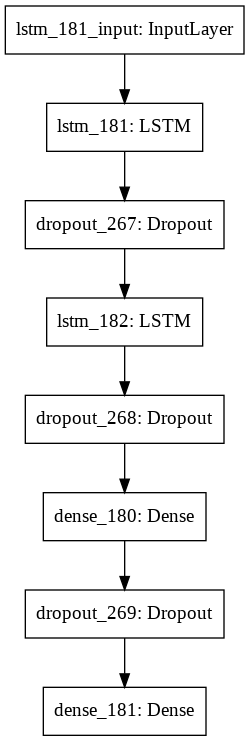

In [0]:
plot_model(model,)

### Predicted

In [0]:
y_pred = model.predict_classes(X)

In [0]:
print_output(y_pred)

1 0 0 0 0 

0 0 0 0 0 

0 0 0 0 0 

0 0 0 0 0 

0 0 0 0 0 

0 0 0 0 0 

0 0 0 0 0 

0 0 0 0 0 

0 0 0 0 0 

0 0 0 0 0 



In [0]:
y_prob = model.predict_proba(X)

In [0]:
print_output(y_prob)

[0.7068873  0.29311275] [9.9999940e-01 5.7026233e-07] [0.98649406 0.01350589] [9.9962115e-01 3.7878953e-04] [1.0000000e+00 5.3582583e-14] 

[0.78984797 0.210152  ] [1.0000000e+00 4.7451856e-08] [1.0000000e+00 1.7979502e-37] [9.9996936e-01 3.0610281e-05] [1.0000000e+00 2.6070932e-24] 

[0.81983393 0.18016611] [0.9366029  0.06339709] [9.999604e-01 3.954318e-05] [9.9998224e-01 1.7764911e-05] [9.999043e-01 9.573362e-05] 

[9.9989367e-01 1.0637499e-04] [0.9978382  0.00216177] [0.9160064  0.08399361] [0.9422238  0.05777622] [0.37246343 0.6275366 ] 

[0.99656075 0.00343928] [9.9987304e-01 1.2689507e-04] [1. 0.] [9.9942762e-01 5.7237037e-04] [0.944977   0.05502301] 

[0.7826486  0.21735133] [0.8884098 0.1115902] [9.9999368e-01 6.3467596e-06] [1.0000000e+00 3.2151717e-38] [0.9945891  0.00541097] 

[9.9998355e-01 1.6394801e-05] [1. 0.] [9.9985778e-01 1.4218176e-04] [9.9998724e-01 1.2711870e-05] [0.6956399 0.3043601] 

[1. 0.] [0.99864656 0.00135348] [0.99887794 0.00112204] [0.98431104 0.01568894

### Save model

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/My Drive/Year4/Project/demo_model/demo_case1_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/Year4/Project/demo_model/demo_case1_weight.h5")

### Load model

In [0]:
json_file = open('/content/gdrive/My Drive/Year4/Project/demo_model100.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

In [0]:
from keras.models import model_from_json

loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/content/gdrive/My Drive/Year4/Project/demo_model100.h5")

In [0]:
loaded_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'],)

In [0]:
y_pred = loaded_model.predict_classes(X)

In [0]:
print_output(y_pred)

0 0 0 0 0 

0 0 0 0 0 

0 0 0 0 0 

1 0 0 0 0 

0 0 0 0 0 

0 0 1 0 0 

0 0 0 0 0 

0 0 0 0 0 

0 0 0 0 0 

0 0 0 0 0 



In [0]:
import cv2 as cv
path_dir = '/content/drive/My Drive/Year4/Project/top_view/'+case[0]
# path_dir = '/top_view/'+str(case)+'/'
# print('getting...')
path = []
for p in os.listdir(path_dir):
  path.append(p)
  path.sort()
# print(path[0:5])
# load data
data = []
for p in path:
  img = cv.imread(path_dir+'/'+p)
  shape = img.shape
  img_resize = cv.resize(img,(int(shape[1]/2),int(shape[0]/2)))
  data.append(img_resize)

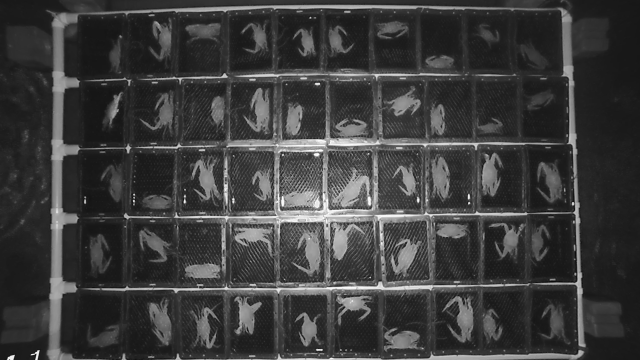

In [0]:
from google.colab.patches import cv2_imshow
cv2_imshow(data[0])

In [0]:
pos = ['A','B','C','D','E']
START_X = 80
START_Y = 15
WIDTH = 38
HEIGHT = 55
DELTA_X = WIDTH + 12
DELTA_Y = HEIGHT + 15

def draw_ans(img):
  for i in range(len(y_pred)):
    # print("{0},{1}".format((i//5)+1,i%5))
    x = START_X+(DELTA_X*(i//5)+1)
    y = START_Y+(DELTA_Y*(i%5))
    if(y_pred[i] == 0):
      color = (0,255,0)
    elif(y_pred[i] == 1):
      color = (255,0,255)
    cv.rectangle(img,(x,y),(x+WIDTH,y+HEIGHT),color,1)
    # print("{0}{1}".format(pos[i%5],(i//5)+1),end=' ')
    # if((i+1)%5 == 0):
    #   print()
  return img
ans = []
for i in range(len(data)):
  img = np.array(data[i])
  ans.append(draw_ans(img))

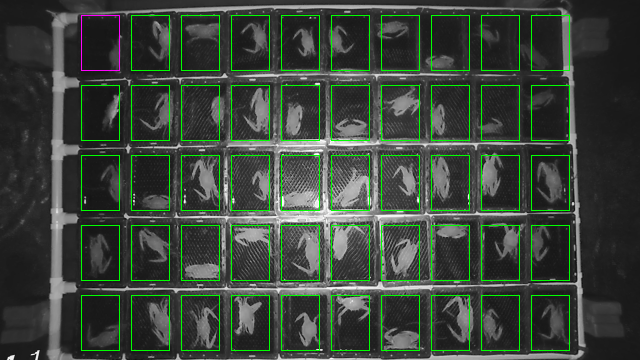

In [0]:
cv2_imshow(ans[0])

In [0]:
import imageio

images = []
# for file_name in os.listdir(png_dir):
#   images.append(imageio.imread(file_path))
imageio.mimsave('/content/drive/My Drive/Year4/Project/demo_model/result.gif', ans)